In [6]:
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report, auc, roc_auc_score,plot_confusion_matrix,roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import joblib
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [7]:
# UnderSampling

In [8]:
def data_read():
    global df
    df = pd.read_csv('./CC_Fraud_Detection/CC_fraudTrain.csv')
    global test
    test = pd.read_csv('./CC_Fraud_Detection/CC_fraudTest.csv')
    df_final = pd.concat([df,test],axis=0)
    return df_final

In [9]:
def undersampling(df_final):
    df_fraud = df_final.loc[df_final['is_fraud']==1].copy()
    df_non_fraud = df_final.loc[df_final['is_fraud']==0].copy()
    df_non_fraud = df_non_fraud.sample(df_fraud.shape[0], random_state=42)
    df_fraud.reset_index(drop=True,inplace=True)
    df_non_fraud.reset_index(drop=True,inplace=True)
    df_final = pd.concat([df_fraud,df_non_fraud],axis=0)
    
    return df_final

In [10]:
def feature_engineering(df_final):
    df_final.reset_index(drop=True,inplace=True)
    df_final['age']=pd.to_datetime(df_final['trans_date_trans_time']).dt.year-pd.to_datetime(df_final['dob']).dt.year
    df_final['hour']=pd.to_datetime(df_final['trans_date_trans_time']).dt.hour
    df_final['day']=pd.to_datetime(df_final['trans_date_trans_time']).dt.dayofweek
    df_final['month']=pd.to_datetime(df_final['trans_date_trans_time']).dt.month
    
    df_final = df_final[['category','amt','zip','lat','long','city_pop','merch_lat','merch_long','age','hour','day','month','is_fraud']]
    return df_final
    
    

In [11]:
def train_test(df_final):
    X = df_final.drop(columns='is_fraud')
    y = df_final['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42,stratify = y)

    global encoder
    X_train.reset_index(drop=True,inplace=True)
    encoder = OneHotEncoder(sparse=False,drop='first')
    df_encoded = pd.DataFrame (encoder.fit_transform(X_train[['category']]))
    df_encoded.columns = encoder.get_feature_names(['category'])
    X_train.drop(['category'] ,axis=1, inplace=True)
    X_train= pd.concat([X_train, df_encoded ], axis=1)
    
    X_test.reset_index(drop=True,inplace=True)
    df_encoded = pd.DataFrame (encoder.transform(X_test[['category']]))
    df_encoded.columns = encoder.get_feature_names(['category'])
    X_test.drop(['category'] ,axis=1, inplace=True)
    X_test= pd.concat([X_test, df_encoded ], axis=1)
    
    return X_train, X_test, y_train, y_test
    

In [12]:
def hyper_parameter_tunning(X_train, X_test, y_train, y_test):
    n_estimators = [100,200,300,50,500,400]
    max_features = [0.3,0.2,0.7,1.0,0.6,0.8,0.9]
    max_depth = [10,5,8,None]
    max_samples = [0.25,0.50,0.75,1.0,0.85]
    bootstrap = [True, False]
    
    grid_param = {
    'n_estimators':n_estimators,
    "max_features":max_features,
    "max_depth":max_depth,
    "bootstrap":bootstrap
    }
    random_forest_grid = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                           param_distributions=grid_param,
                                           cv=5,
                                           verbose=2,
                                           n_jobs=-1)
    random_forest_grid.fit(X_train,y_train)

    print("best param\n",random_forest_grid.best_params_)
    print("best score\n",random_forest_grid.best_score_)
    predicted = random_forest_grid.predict(X_test)
    print('Classification report:\n', classification_report(y_test, predicted))
    conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
    print('Confusion matrix:\n', conf_mat)
    
    return random_forest_grid
    


In [87]:
def imbalance_plots(df_final):
    
    plt.figure(figsize=(10,8))
    ax= sns.countplot(x= 'is_fraud',data = df_final)
    t= len(df_final)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.title("Original Class Distribution")
    plt.savefig("./Images/class_distribution/original_class.png",dpi=700)
    plt.xlabel("Fraud")
    plt.show()
#     plt.savefig("Target_Without_SMOTE.png",dpi=700)

In [88]:
def undersampling_plots(df_final):
    plt.figure(figsize=(10,8))
    ax= sns.countplot(x= 'is_fraud',data = df_final)
    t= len(df_final)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / t:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    plt.title("Undersampling Majority Class")
    plt.xlabel("Fraud")
    plt.savefig("./Images/class_distribution/undersampling_majority_class.png",dpi=700)
    plt.show()

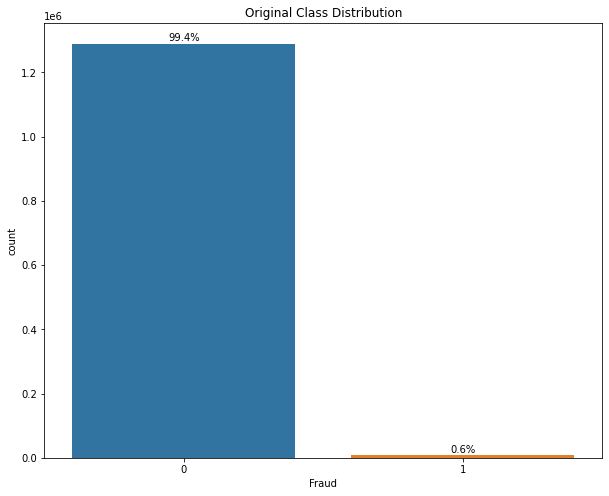

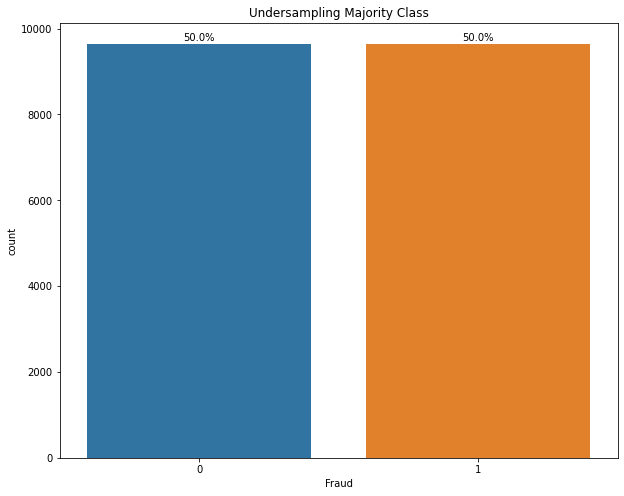

In [89]:
df_final = data_read()
df_final = undersampling(df_final)
df_final = feature_engineering(df_final)
X_train, X_test, y_train, y_test = train_test(df_final)
imbalance_plots(df)
undersampling_plots(df_final)
# random_forest_grid = hyper_parameter_tunning(X_train, X_test, y_train, y_test)

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1931
           1       0.98      0.98      0.98      1930

    accuracy                           0.98      3861
   macro avg       0.98      0.98      0.98      3861
weighted avg       0.98      0.98      0.98      3861

Confusion matrix:
 [[1899   32]
 [  30 1900]]


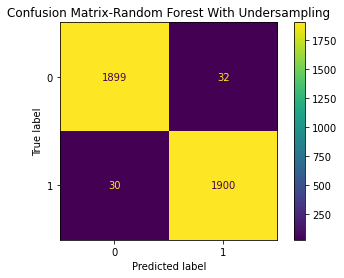

In [83]:
randforest_model = RandomForestClassifier(n_estimators=400,max_features=0.9,max_depth=None,bootstrap=True,n_jobs=-1)
randforest_model.fit(X_train,y_train)
predicted=randforest_model.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(randforest_model, X_test, y_test)
plt.title('Confusion Matrix-Random Forest With Undersampling')
plt.savefig("./Images/Undersampling/confusion_matrix_random_forest_undersampling.png",dpi=700)

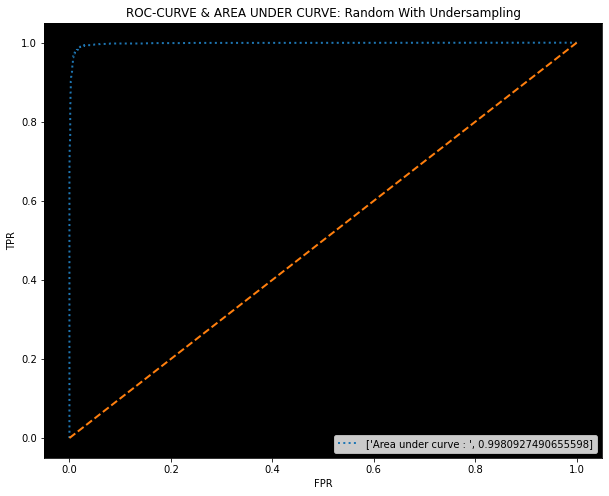

In [84]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
randforest_model_y_predicted = randforest_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, randforest_model_y_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Random Forest With Undersampling")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC-CURVE & AREA UNDER CURVE: Random With Undersampling")
plt.savefig("./Images/Undersampling/random_forest_with Undersampling_ROC_AUC.png",dpi=700)

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87      1931
           1       0.94      0.76      0.84      1930

    accuracy                           0.86      3861
   macro avg       0.87      0.86      0.86      3861
weighted avg       0.87      0.86      0.86      3861

Confusion matrix:
 [[1840   91]
 [ 457 1473]]


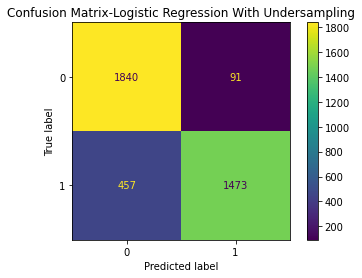

In [85]:
# Logistic Regression- Undersampling

log_regression_undersampling=LogisticRegression()
log_regression_undersampling.fit(X_train,y_train)
predicted=log_regression_undersampling.predict(X_test)

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(log_regression_undersampling, X_test, y_test)
plt.title('Confusion Matrix-Logistic Regression With Undersampling')
plt.savefig("./Images/Undersampling/confusion_matrix_logistic_regression_undersampling.png",dpi=700)

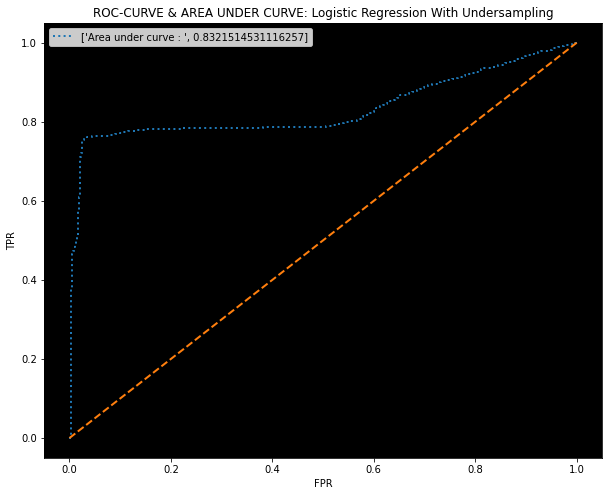

In [86]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
log_regression_undersampling_predicted = log_regression_undersampling.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, log_regression_undersampling_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Logistic Regression With Undersampling")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("./Images/Undersampling/logistic_regression_undersampling_data_ROC_AUC.png",dpi=700)

In [20]:
# without handling data imbalance

In [68]:
df_final = data_read()

In [69]:
train = feature_engineering(df)
test = feature_engineering(test)

In [70]:
train.head()

,category,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,month,is_fraud
0,misc_net,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,31,0,1,1,0
1,grocery_pos,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,41,0,1,1,0
2,entertainment,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,57,0,1,1,0
3,gas_transport,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,52,0,1,1,0
4,misc_pos,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,33,0,1,1,0


In [71]:
X_train = train.drop(columns='is_fraud')
y_train = train['is_fraud']

In [72]:
print(X_test.shape)

(3861, 24)


In [73]:
non_fraud = test.loc[test['is_fraud']==0]
fraud = test.loc[test['is_fraud']==1]

non_fraud = non_fraud.sample(round(X_test.shape[0]/2)+1,random_state=42)
fraud = fraud.sample(round(X_test.shape[0]/2),random_state=42)

non_fraud.reset_index(drop=True,inplace=True)
fraud.reset_index(drop=True,inplace=True)
no_sampling = pd.concat([fraud,non_fraud],axis=0)
no_sampling = no_sampling.iloc[1:,].copy()

In [74]:
X_test = no_sampling.drop(columns='is_fraud')
y_test = no_sampling['is_fraud']

In [75]:
# encoding for no sampling method
X_train.reset_index(drop=True,inplace=True)
encoder = OneHotEncoder(sparse=False,drop='first')
df_encoded = pd.DataFrame (encoder.fit_transform(X_train[['category']]))
df_encoded.columns = encoder.get_feature_names(['category'])
X_train.drop(['category'] ,axis=1, inplace=True)
X_train= pd.concat([X_train, df_encoded ], axis=1)

X_test.reset_index(drop=True,inplace=True)
df_encoded = pd.DataFrame (encoder.transform(X_test[['category']]))
df_encoded.columns = encoder.get_feature_names(['category'])
X_test.drop(['category'] ,axis=1, inplace=True)
X_test= pd.concat([X_test, df_encoded ], axis=1)

In [76]:
X_train

,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,28654,36.0788,-81.1781,3495,36.011293,-82.048315,31,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,107.23,99160,48.8878,-118.2105,149,49.159047,-118.186462,41,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,220.11,83252,42.1808,-112.2620,4154,43.150704,-112.154481,57,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.00,59632,46.2306,-112.1138,1939,47.034331,-112.561071,52,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.96,24433,38.4207,-79.4629,99,38.674999,-78.632459,33,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,84735,37.7175,-112.4777,258,36.841266,-111.690765,59,12,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296671,51.70,21790,39.2667,-77.5101,100,38.906881,-78.246528,41,12,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296672,105.93,88325,32.9396,-105.8189,899,33.619513,-105.130529,53,12,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296673,74.90,57756,43.3526,-102.5411,1126,42.788940,-103.241160,40,12,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Classification report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88      1931
           1       1.00      0.74      0.85      1929

    accuracy                           0.87      3860
   macro avg       0.89      0.87      0.87      3860
weighted avg       0.89      0.87      0.87      3860

Confusion matrix:
 [[1926    5]
 [ 503 1426]]


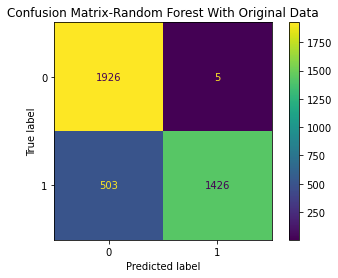

In [77]:

# Random Foreset For No Sampling
randforest_model_no_samp = RandomForestClassifier(n_estimators=1,max_features=0.3,max_depth=None,bootstrap=False,n_jobs=-1)
randforest_model_no_samp.fit(X_train,y_train)
predicted=randforest_model_no_samp.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(randforest_model_no_samp, X_test, y_test)
plt.title('Confusion Matrix-Random Forest With Original Data')
plt.savefig("./Images/Original/confusion_matrix_random_forest_model_original_data.png",dpi=700)

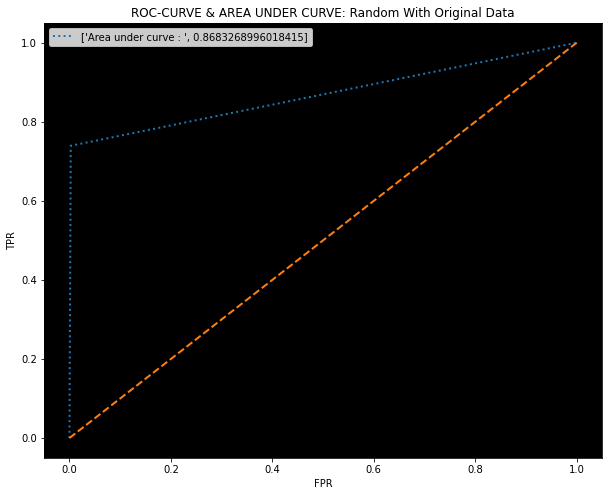

In [81]:
# Random Forest No Sampling
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
randforest_model_no_samp_predicted = randforest_model_no_samp.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, randforest_model_no_samp_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Random With Original Data")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("./Images/Original/random_forest_original_data_ROC_AUC.png",dpi=700)

Classification report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      1931
           1       0.00      0.00      0.00      1929

    accuracy                           0.50      3860
   macro avg       0.25      0.50      0.33      3860
weighted avg       0.25      0.50      0.33      3860

Confusion matrix:
 [[1930    1]
 [1929    0]]


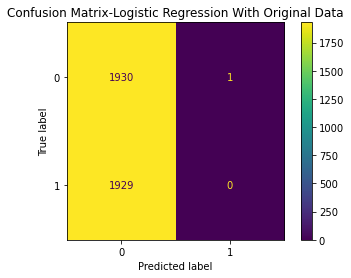

In [79]:
# Logistic Regression- No sampling

log_regression_nosampling=LogisticRegression()
log_regression_nosampling.fit(X_train,y_train)
predicted=log_regression_nosampling.predict(X_test)

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(log_regression_nosampling, X_test, y_test)
plt.title('Confusion Matrix-Logistic Regression With Original Data')
plt.savefig("./Images/Original/confusion_matrix_logistic_regression_original_data.png",dpi=700)

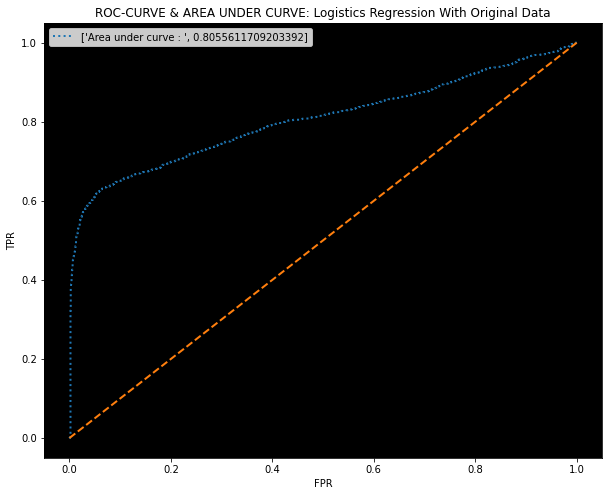

In [80]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
log_regression_nosampling_predicted = log_regression_nosampling.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, log_regression_nosampling_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Logistics Regression With Original Data")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("./Images/Original/logistics_regression_Original_ROC_AUC.png",dpi=700)

In [37]:
X_train_smote = X_train.copy()
y_train_smote = y_train.copy()

In [38]:
# Oversampling SMOTE
sampling_method = SMOTE()
X_resampled, y_resampled = sampling_method.fit_resample(X_train_smote, y_train_smote)

Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1931
           1       1.00      0.80      0.89      1929

    accuracy                           0.90      3860
   macro avg       0.92      0.90      0.90      3860
weighted avg       0.92      0.90      0.90      3860

Confusion matrix:
 [[1930    1]
 [ 392 1537]]


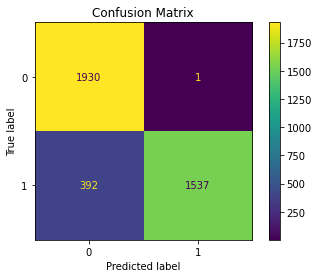

In [46]:
randforest_model_with_smote = RandomForestClassifier(n_estimators=400,max_features=0.9,max_depth=None,bootstrap=True,n_jobs=-1)
randforest_model_with_smote.fit(X_resampled,y_resampled)


Classification report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1931
           1       1.00      0.80      0.89      1929

    accuracy                           0.90      3860
   macro avg       0.92      0.90      0.90      3860
weighted avg       0.92      0.90      0.90      3860

Confusion matrix:
 [[1930    1]
 [ 392 1537]]


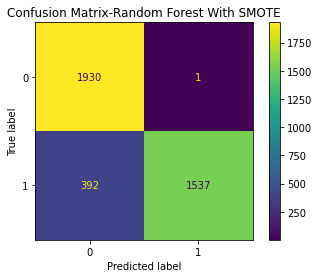

In [53]:
predicted=randforest_model_with_smote.predict(X_test)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(randforest_model_with_smote, X_test, y_test)
plt.title('Confusion Matrix-Random Forest With SMOTE')
plt.savefig("./Images/SMOTE/confusion_matrix_random_forest_model_with_SMOTE.png",dpi=700)
plt.show()

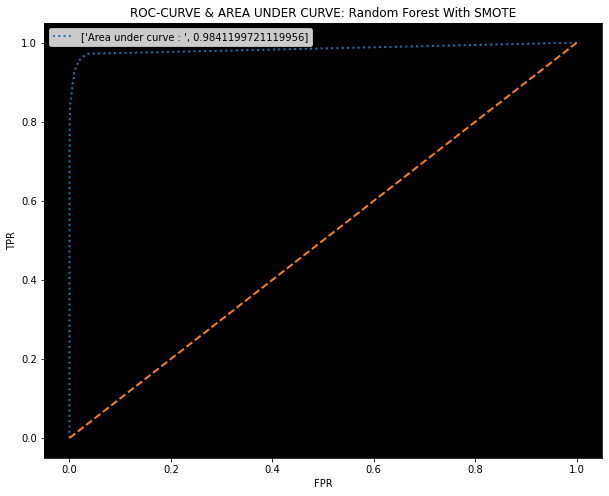

In [63]:
# Roc Auc curve for random forest Smote
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
randforest_model_with_smote_y_predicted = randforest_model_with_smote.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, randforest_model_with_smote_y_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Random Forest With SMOTE")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("./Images/SMOTE/reandom_forest_with_smote_ROC_AUC.png",dpi=700)

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86      1931
           1       0.94      0.75      0.83      1929

    accuracy                           0.85      3860
   macro avg       0.87      0.85      0.85      3860
weighted avg       0.87      0.85      0.85      3860

Confusion matrix:
 [[1839   92]
 [ 484 1445]]


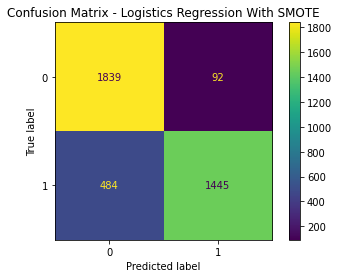

In [62]:
# Logistic Regression- Oversampling

log_regression_nosampling=LogisticRegression()
log_regression_nosampling.fit(X_resampled,y_resampled)
predicted=log_regression_nosampling.predict(X_test)

print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

plot_confusion_matrix(log_regression_nosampling, X_test, y_test)
plt.title('Confusion Matrix - Logistics Regression With SMOTE')
plt.savefig("./Images/SMOTE/confusion_matrix_logistics_regression_SMOTE_ROC_AUC.png",dpi=700)

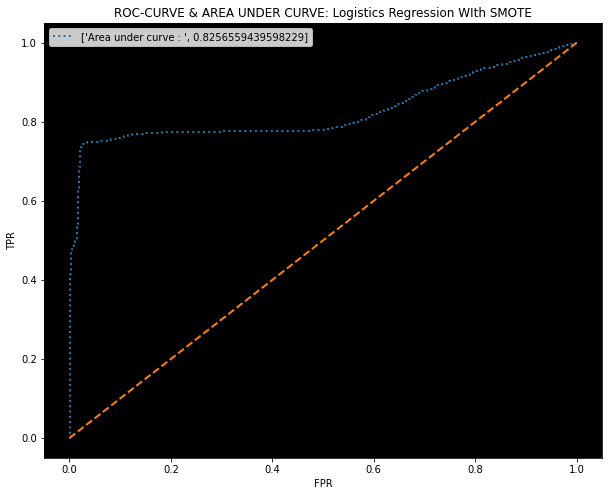

In [61]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
log_regression_nosampling_predicted = log_regression_nosampling.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, log_regression_nosampling_predicted)
ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
plt.legend(loc="best")
plt.title("ROC-CURVE & AREA UNDER CURVE: Logistics Regression WIth SMOTE")
ax.set_facecolor("k")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("./Images/SMOTE/logistics_regression_SMOTE_ROC_AUC.png",dpi=700)

In [91]:
y_resampled.value_counts()

0    1289169
1    1289169
Name: is_fraud, dtype: int64

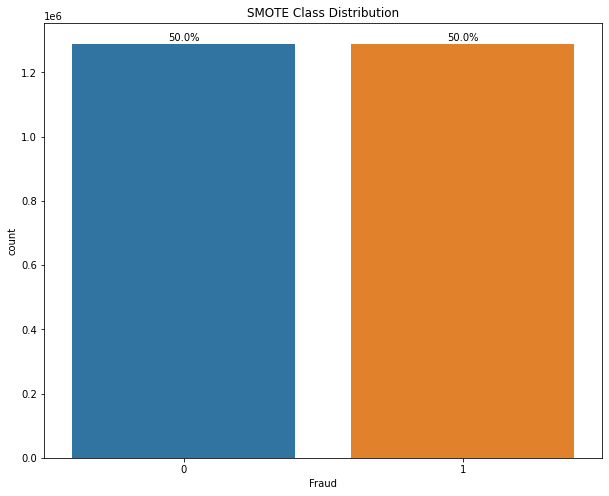

In [93]:
plt.figure(figsize=(10,8))
ax= sns.countplot(x= y_resampled)
t= len(y_resampled)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / t:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.title("SMOTE Class Distribution")
plt.xlabel("Fraud")
plt.savefig("./Images/class_distribution/SMOTE.png",dpi=700)
plt.show()